In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm 
import matplotlib.pyplot as plt
import os
from catboost import CatBoostClassifier, Pool, cv
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.model_selection import cross_validate
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder,LabelEncoder,MaxAbsScaler,RobustScaler
from sklearn.metrics import f1_score, accuracy_score
from imblearn.over_sampling import BorderlineSMOTE,ADASYN,SMOTE,SVMSMOTE
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.svm import SVC
from math import ceil
from numpy.random import RandomState
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.feature_selection import SelectKBest,f_classif,mutual_info_classif
from sklearn.model_selection import GridSearchCV  

from sklearn.tree import DecisionTreeClassifier


### Functions

In [2]:
def bar_charts_categorical(df, feature, target):
    cont_tab = pd.crosstab(df[feature], df[target], margins = True)
    categories = cont_tab.index[:-1]
        
    fig = plt.figure(figsize=(15, 5))
    
    plt.subplot(121)
    p1 = plt.bar(categories, cont_tab.iloc[:-1, 0].values, 0.55, color="gray")
    p2 = plt.bar(categories, cont_tab.iloc[:-1, 1].values, 0.55, bottom=cont_tab.iloc[:-1, 0], color="yellowgreen")
    plt.legend((p2[0], p1[0]), ('$y_i=1$', '$y_i=0$'))
    plt.title("Frequency bar chart")
    plt.xlabel(feature)
    plt.xticks(rotation="vertical")
    plt.ylabel("$Frequency$")

    # auxiliary data for 122
    obs_pct = np.array([np.divide(cont_tab.iloc[:-1, 0].values, cont_tab.iloc[:-1, 2].values), 
                        np.divide(cont_tab.iloc[:-1, 1].values, cont_tab.iloc[:-1, 2].values)])
      
    plt.subplot(122)
    p1 = plt.bar(categories, obs_pct[0], 0.55, color="gray")
    p2 = plt.bar(categories, obs_pct[1], 0.55, bottom=obs_pct[0], color="yellowgreen")
    plt.legend((p2[0], p1[0]), ('$y_i=1$', '$y_i=0$'),labelspacing =1)
    plt.title("Proportion bar chart")
    plt.xlabel(feature)
    plt.ylabel("$p$")
    plt.xticks(rotation="vertical")
    plt.show()
    

In [3]:
def metrics(y_train, pred_train , y_val, pred_val):
    print('___________________________________________________________________________________________________________')
    print('                                                     TRAIN                                                 ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(classification_report(y_train, pred_train))
    print(confusion_matrix(y_train, pred_train))


    print('___________________________________________________________________________________________________________')
    print('                                                VALIDATION                                                 ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(classification_report(y_val, pred_val))
    print(confusion_matrix(y_val, pred_val))

In [4]:
def best_scale(model,X_train,y_train,X_test,y_test):
    standard=StandardScaler().fit(X_train).transform(X_train)
    standardTest=StandardScaler().fit(X_test).transform(X_test)

    minMax=MinMaxScaler().fit(X_train).transform(X_train)
    minMaxTest=MinMaxScaler().fit(X_test).transform(X_test)

    maxAbs=MaxAbsScaler().fit(X_train).transform(X_train)
    maxAbsTest=MaxAbsScaler().fit(X_test).transform(X_test)
        
    robust=RobustScaler().fit(X_train).transform(X_train)
    robustTest=RobustScaler().fit(X_test).transform(X_test)

    sclares=[standard,minMax,maxAbs,robust,X_train]
    sclaresTest=[standardTest,minMaxTest,maxAbsTest,robustTest,X_test]
    
    f_score=[]
    
    for i in range(len(sclares)):
        model.fit(sclares[i],y_train)
        y_pred=model.predict(sclaresTest[i])
        f_score.append(f1_score(y_pred,y_test))
        

    return pd.DataFrame(f_score,index=["Standard","MinMax","MaxAbs","Robust","No Scaler"], columns=["F1 Score"])
    

### Reading the Data

In [5]:
df = pd.read_excel("train.xlsx")
df.head()

,CITIZEN_ID,Name,Birthday,Native Continent,Marital Status,Lives with,Base Area,Education Level,Years of Education,Employment Sector,Role,Working Hours per week,Money Received,Ticket Price,Income
0,12486,Mr. Adam Glover,"July 1,2003",Europe,Married,Wife,Northbury,High School + PostGraduation,13,Private Sector - Services,Repair & constructions,40,0,2273,1
1,12487,Mr. Cameron McDonald,"January 25,2006",Europe,Married,Wife,Northbury,Professional School,12,Public Sector - Others,Repair & constructions,40,0,0,1
2,12488,Mr. Keith Davidson,"May 10,2009",Europe,Married,Wife,Northbury,Professional School,12,Private Sector - Services,Sales,46,0,2321,1
3,12489,Mr. Alexander Gill,"March 25,1985",Europe,Married,Wife,Northbury,High School - 2nd Cycle,11,Private Sector - Services,Security,37,5395,0,1
4,12490,Mr. Neil Piper,"May 29,2015",Europe,Single,Other Family,Northbury,PhD,21,Self-Employed (Individual),Professor,45,0,0,1


In [6]:
original = df.copy()

In [7]:
df.replace("?", np.nan, inplace=True)
df.isna().sum()

CITIZEN_ID                   0
Name                         0
Birthday                     0
Native Continent             0
Marital Status               0
Lives with                   0
Base Area                  395
Education Level              0
Years of Education           0
Employment Sector         1264
Role                      1271
Working Hours per week       0
Money Received               0
Ticket Price                 0
Income                       0
dtype: int64

In [8]:
df.isna().sum()/len(df)*100

CITIZEN_ID                0.000000
Name                      0.000000
Birthday                  0.000000
Native Continent          0.000000
Marital Status            0.000000
Lives with                0.000000
Base Area                 1.763393
Education Level           0.000000
Years of Education        0.000000
Employment Sector         5.642857
Role                      5.674107
Working Hours per week    0.000000
Money Received            0.000000
Ticket Price              0.000000
Income                    0.000000
dtype: float64

In [9]:
df[["Gender","Name"]]=df["Name"].str.split(" ", n=1,expand=True)
df["Gender"].replace(["Mr."],"M",inplace=True)
df["Gender"].replace(["Miss","Mrs."],"F",inplace=True)

In [10]:
df[["Mouth","Year"]]=df['Birthday'].str.split(",",expand=True)
df["Year"]=df["Year"].astype(int)
df["Age"] = 2046 - df["Year"]

In [11]:
df.set_index("CITIZEN_ID",inplace=True)

In [12]:
df.drop(["Name","Mouth","Year","Birthday"],inplace=True,axis=1)

### New variables

In [13]:
#df["Working Hours per week/age"]=df["Working Hours per week"]/df["Age"]*100
#df["Years of Education/age"]=df["Years of Education"]/df["Age"]*100
#df["Working Hours per week/Years of Education"]=df["Working Hours per week"]/df["Years of Education"]

In [14]:
categorical = df.select_dtypes(include="object").columns.to_list()
numerical = df.columns.drop(categorical).drop("Income").to_list()

### Visualize

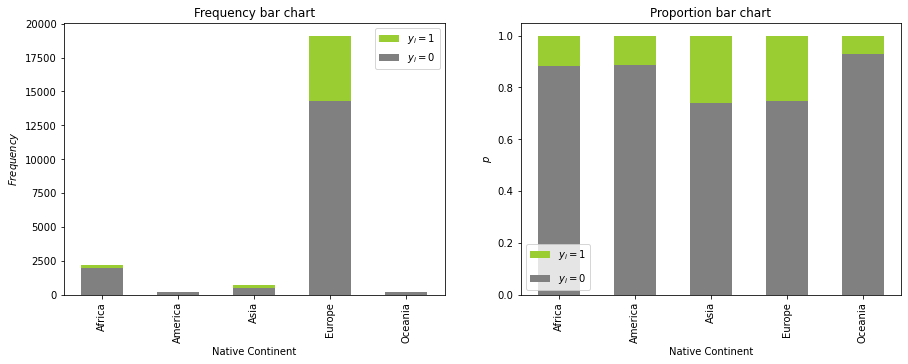

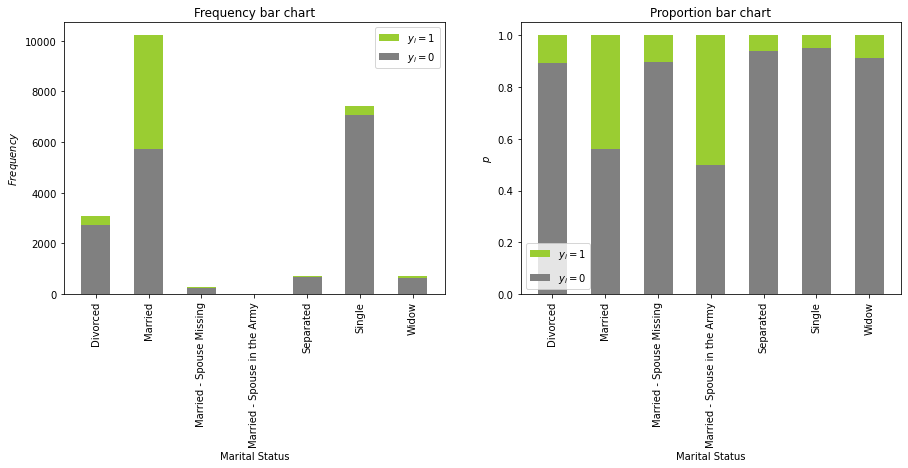

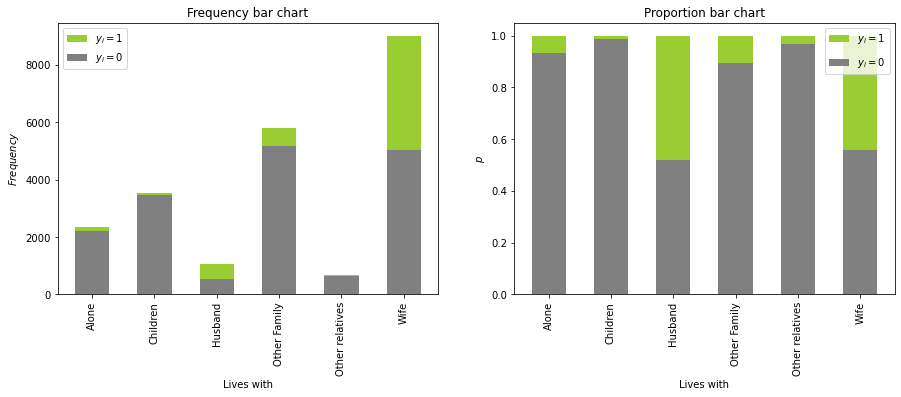

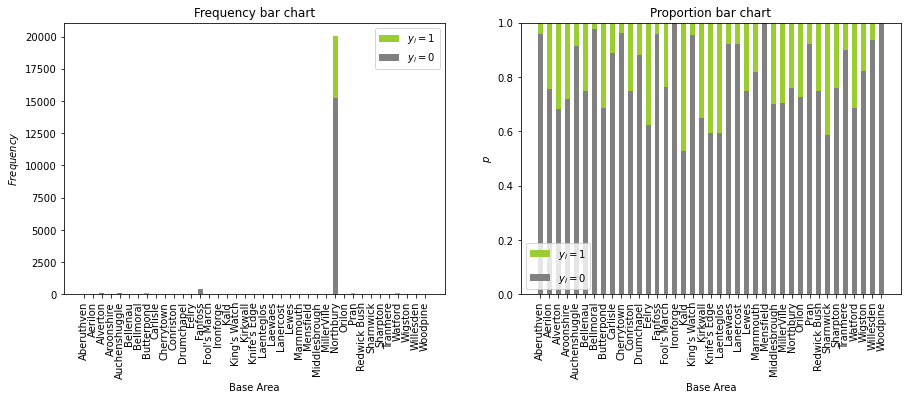

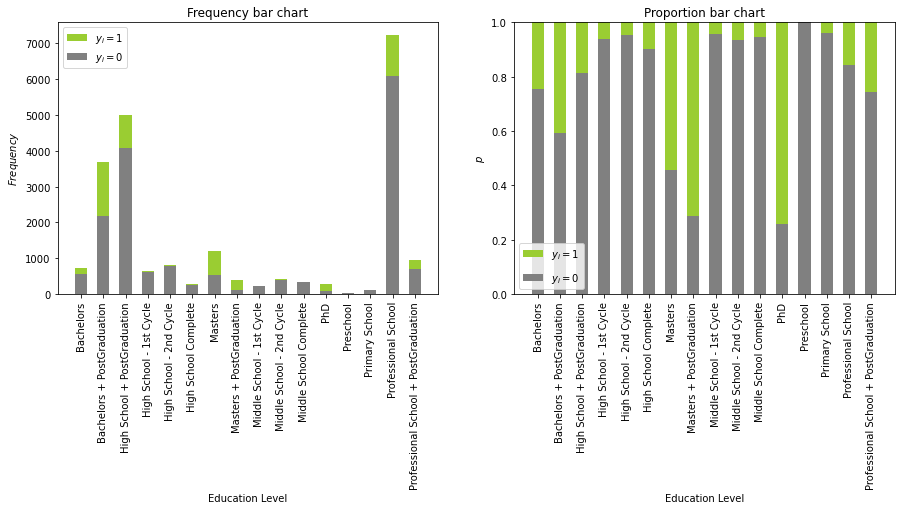

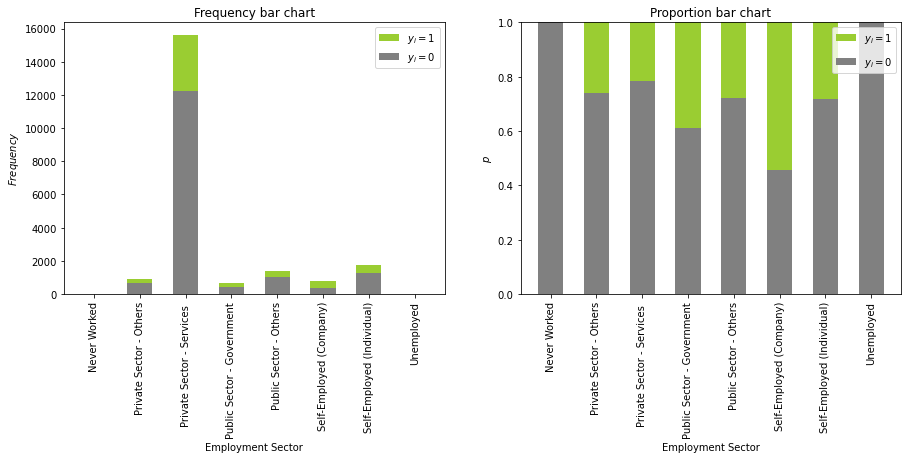

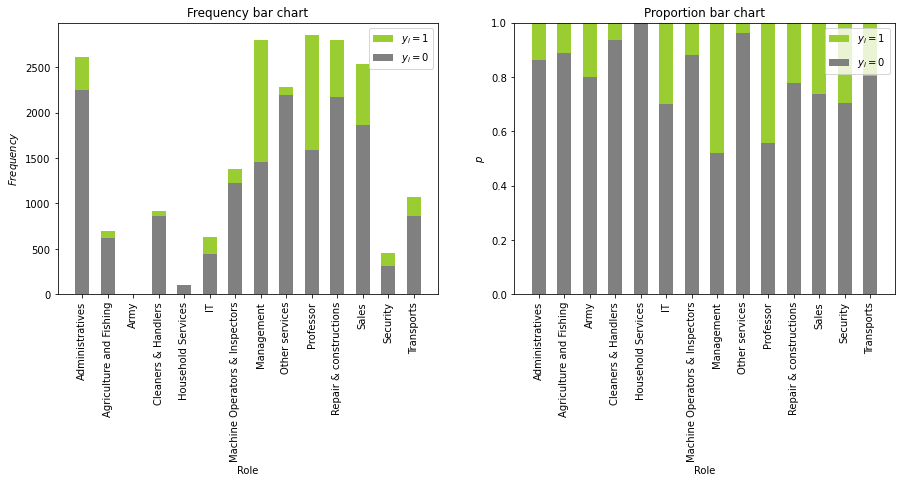

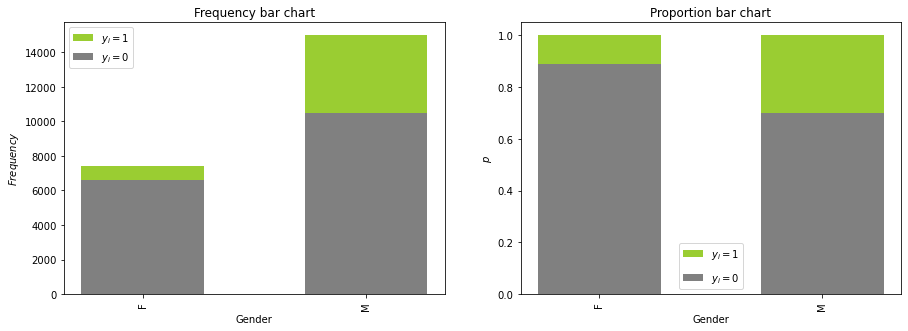

In [15]:
for i in categorical:   
    bar_charts_categorical(df, i, "Income")

In [16]:
df["Marital Status"].replace(["Married - Spouse in the Army" ],"Married",inplace=True)
df["Marital Status"].replace(["Married - Spouse Missing" ,"Widow","Divorced"],"Other",inplace=True)

In [17]:
df["Lives with"].replace(["Husband","Wife" ],"Partner",inplace=True)
df["Lives with"].replace(["Other relatives","Children"],"Other",inplace=True)

In [18]:
#tem demasiadas categorias
df.drop(["Base Area"],axis=1,inplace=True)
categorical.remove("Base Area")

In [19]:
df["Education Level"].replace(["High School - 2nd Cycle","High School - 1st Cycle","Middle School Complete","Primary School","Preschool","High School Complete","High School - 1st Cycle","High School - 2nd Cycle","Professional School","Middle School - 1st Cycle","Middle School - 2nd Cycle"],"No college degree",inplace=True)
df["Education Level"].replace(["High School + PostGraduation","Bachelors","Professional School + PostGraduation"],"1 Degree",inplace=True)
df["Education Level"].replace(["Bachelors + PostGraduation","Masters"],"2 Degrees",inplace=True)
df["Education Level"].replace(["Masters + PostGraduation","PhD"],"3 Degrees",inplace=True)

In [20]:
df["Employment Sector"].replace(["Private Sector - Services ","Private Sector - Others"],"Private Sector",inplace=True)
df["Employment Sector"].replace(["Public Sector - Others","Public Sector - Government"],"Public Sector",inplace=True)
df["Employment Sector"].replace(["Unemployed","Never Worked"],"Other",inplace=True)

In [21]:
df["Role"].replace(["Cleaners & Handlers","Machine Operators & Inspectors","Administratives","Agriculture and Fishing","Household Services"],"Other services",inplace=True)

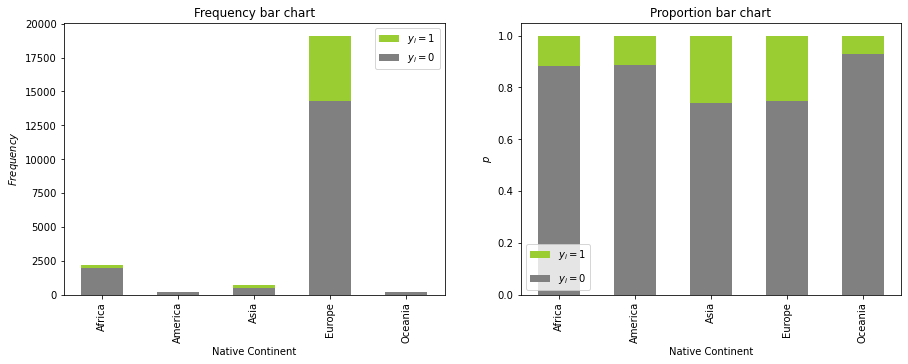

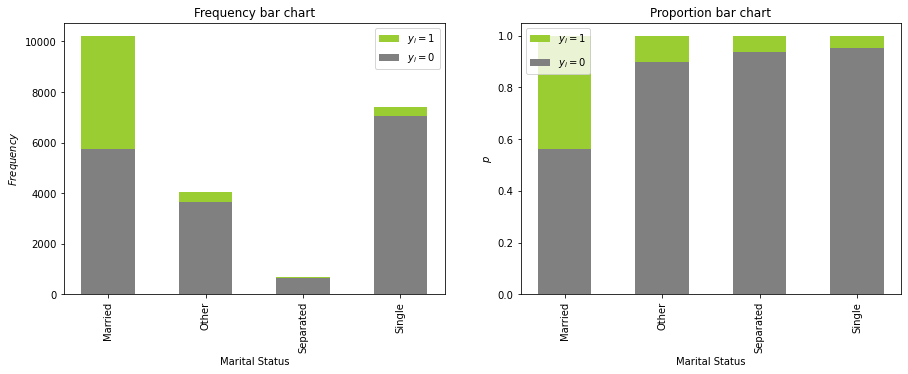

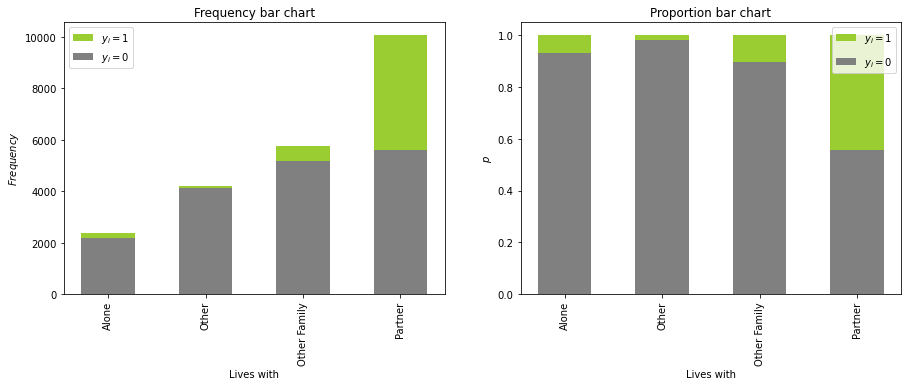

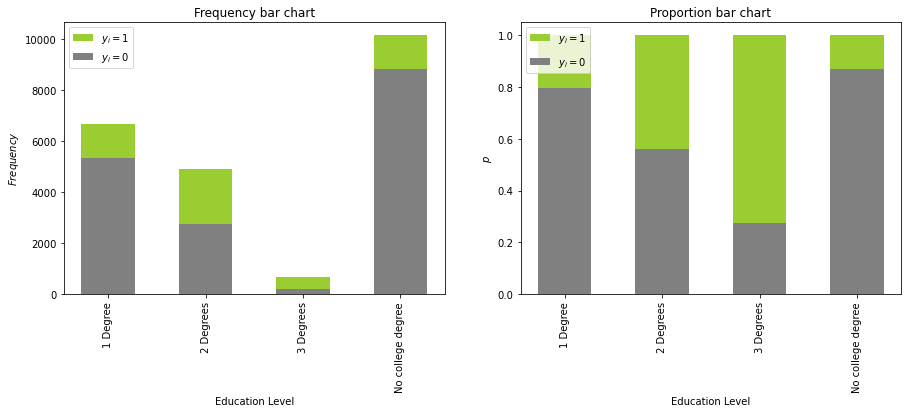

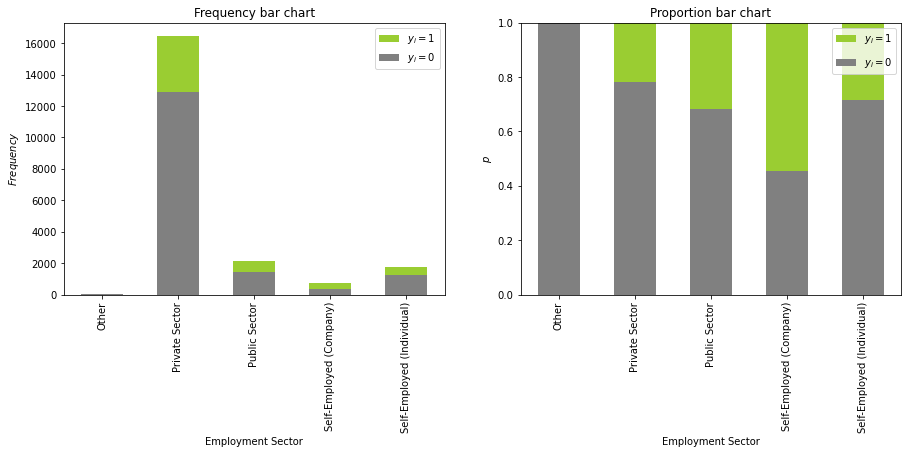

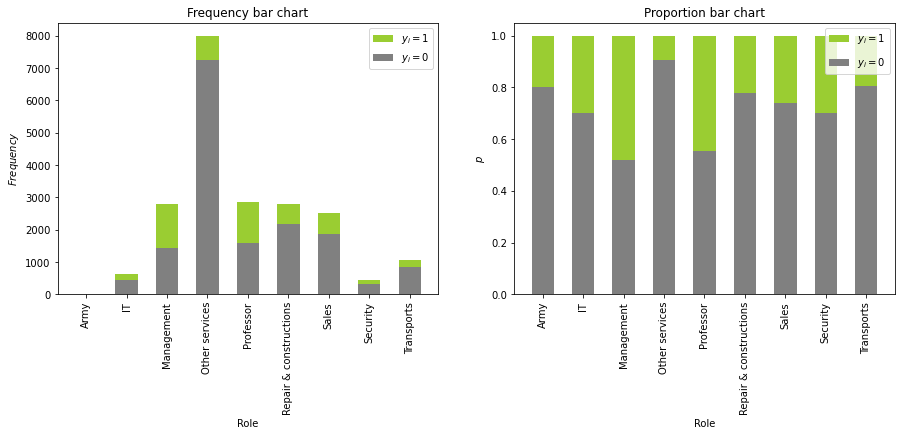

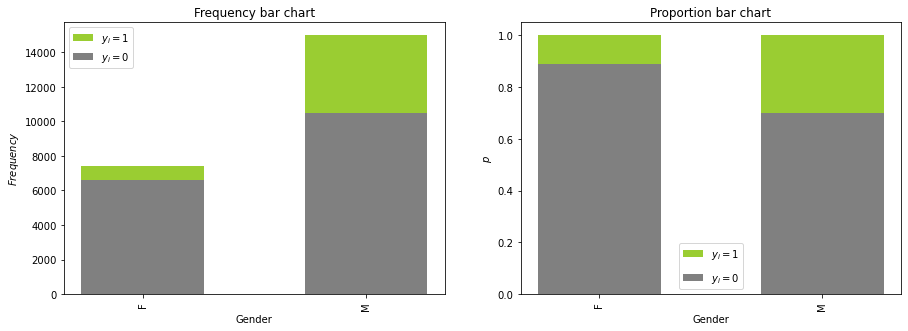

In [22]:
for i in categorical:   
    bar_charts_categorical(df, i, "Income")

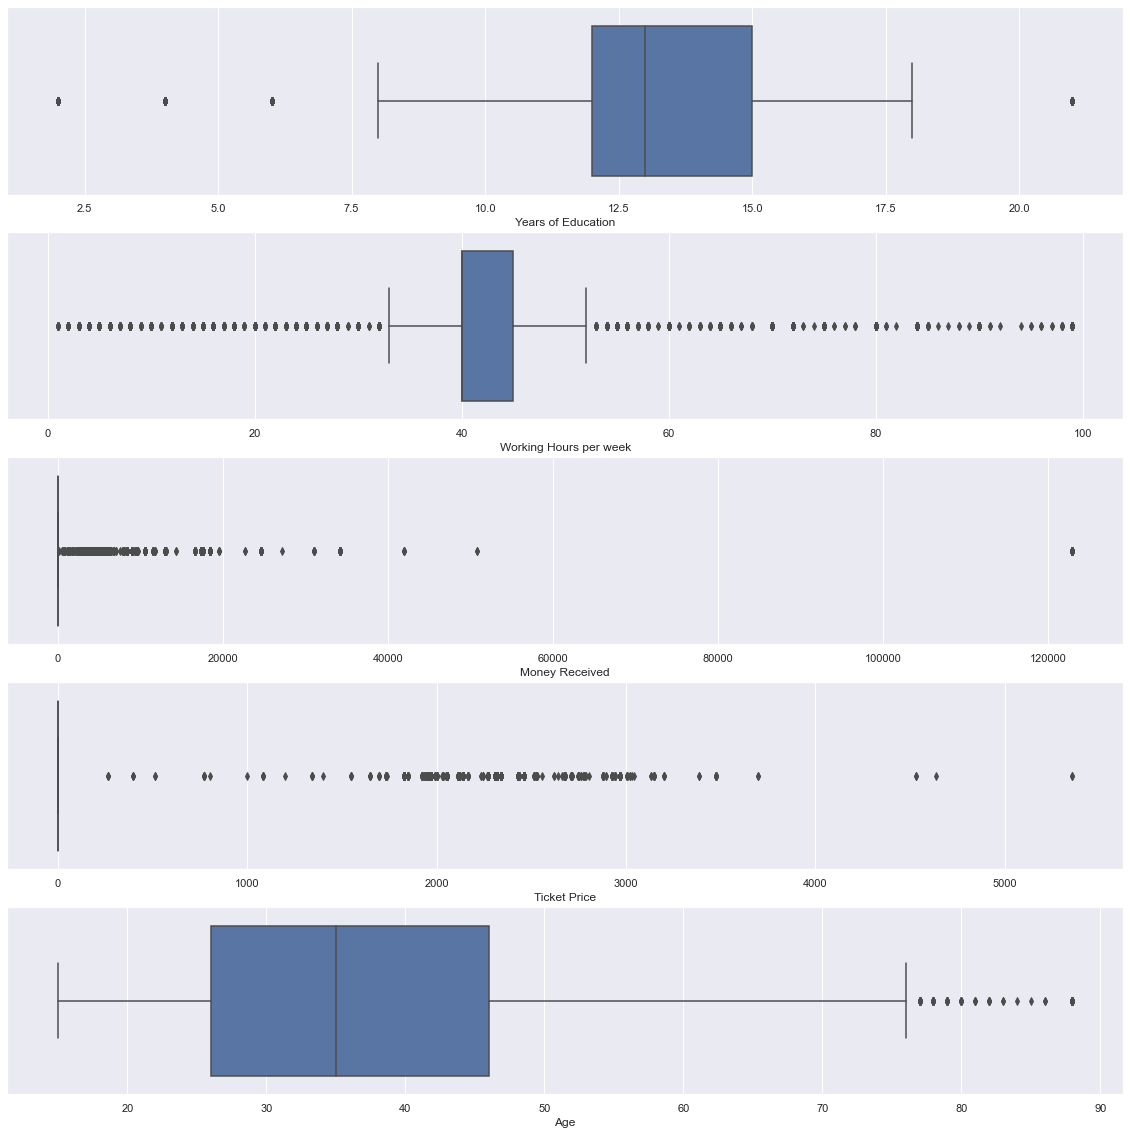

In [23]:
sns.set()
fig, axes = plt.subplots(len(numerical), ceil(len(numerical) / len(numerical)), figsize=(20, 20))
for ax, feat in zip(axes.flatten(), numerical):
    sns.boxplot(x=df[feat], ax=ax) 
plt.show()

### Fill Missing Values

In [24]:
modes = df[categorical].mode().loc[0]
df.fillna(modes,inplace=True)

### Removing Outliers

In [25]:
filters = (
    (df["Working Hours per week"]>7)
    & 
    (df["Years of Education"]<20)
    &
    (df["Ticket Price"]<4000)
    &
    (df["Money Received"]<120000))

df1=df[filters]
print('Percentage of data kept after removing outliers:', np.round(df1.shape[0] / original.shape[0], 4))
df=df1.copy()

Percentage of data kept after removing outliers: 0.9735


### Separating X and Y

In [26]:
X=df.drop(["Income","Native Continent"],axis=1)
y=df.loc[:,"Income"]
categorical=X.select_dtypes(include="object").columns.to_list()

### One Hot Encoder

In [27]:
df_ohc = X.copy()
categorical=X.select_dtypes(include="object").columns.to_list()
ohc = OneHotEncoder(sparse=False, drop="first")
ohc_feat = ohc.fit_transform(df_ohc[categorical])
ohc_feat_names = ohc.get_feature_names(categorical)
ohc_df = pd.DataFrame(ohc_feat, index=df_ohc.index, columns=ohc_feat_names)  # Why the index=df_ohc.index?
# Reassigning df to contain ohc variables
df_ohc = pd.concat([ohc_df,df_ohc.drop(columns=categorical)], axis=1)
X=df_ohc.copy()
X.head()

,Marital Status_Other,Marital Status_Separated,Marital Status_Single,Lives with_Other,Lives with_Other Family,Lives with_Partner,Education Level_2 Degrees,Education Level_3 Degrees,Education Level_No college degree,Employment Sector_Private Sector,...,Role_Repair & constructions,Role_Sales,Role_Security,Role_Transports,Gender_M,Years of Education,Working Hours per week,Money Received,Ticket Price,Age
CITIZEN_ID,,,,,,,,,,,,,,,,,,,,,
12486,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,13,40,0,2273,43
12487,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,12,40,0,0,40
12488,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,1.0,12,46,0,2321,37
12489,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,1.0,0.0,1.0,11,37,5395,0,61
12491,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,15,30,0,0,22


## Data Splitting

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42) 

In [50]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')
import time
from sklearn.model_selection import KFold
import numpy as np
from sklearn import tree
import matplotlib.pyplot as plt


def avg_score(model):
    # apply kfold
    kf = KFold(n_splits=10)
    # create lists to store the results from the different models 
    score_train = []
    score_test = []
    timer = []
    for train_index, test_index in kf.split(X):
        # get the indexes of the observations assigned for each partition
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        # start counting time
        begin = time.perf_counter()
        # fit the model to the data
        model.fit(X_train, y_train)
        # finish counting time
        end = time.perf_counter()
        # check the mean accuracy for the train
        value_train = model.score(X_train, y_train)
        # check the mean accuracy for the test
        value_test = model.score(X_test,y_test)
        # append the accuracies, the time and the number of iterations in the corresponding list
        score_train.append(value_train)
        score_test.append(value_test)
        timer.append(end-begin)
    # calculate the average and the std for each measure (accuracy, time and number of iterations)
    avg_time = round(np.mean(timer),3)
    avg_train = round(np.mean(score_train),3)
    avg_test = round(np.mean(score_test),3)
    std_time = round(np.std(timer),2)
    std_train = round(np.std(score_train),2)
    std_test = round(np.std(score_test),2)
    
    return str(avg_time) + '+/-' + str(std_time), str(avg_train) + '+/-' + str(std_train),\
str(avg_test) + '+/-' + str(std_test)

In [41]:
from sklearn.tree import export_graphviz
import graphviz
import pydotplus

def plot_tree(model):
    dot_data = export_graphviz(model,
                               feature_names=X_train.columns,  
                               class_names=["Low Income", "Income"],
                               filled=True)
    pydot_graph = pydotplus.graph_from_dot_data(dot_data)
    pydot_graph.set_size('"20,20"')
    return graphviz.Source(pydot_graph.to_string())

In [42]:
def show_results(df, *args):
    """
    Receive an empty dataframe and the different models and call the function avg_score
    """
    count = 0
    # for each model passed as argument
    for arg in args:
        # obtain the results provided by avg_score
        time, avg_train, avg_test = avg_score(arg)
        # store the results in the right row
        df.iloc[count] = time, avg_train, avg_test
        count+=1
    return df

## Building a Decision Tree

In [64]:
dt_gini = DecisionTreeClassifier()

In [65]:
dt_gini.fit(X_train, y_train)

DecisionTreeClassifier()

In [66]:
y_pred = dt_gini.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [67]:
y_pred_prob = dt_gini.predict_proba(X_test)
y_pred_prob

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [68]:
print('The defined three has a depth of ' + str(dt_gini.get_depth()) + ', ' + str(dt_gini.tree_.node_count) + 
      ' nodes and a total of ' + str(dt_gini.get_n_leaves()) + ' leaves.')

The defined three has a depth of 37, 6141 nodes and a total of 3071 leaves.


In [69]:
dt_entropy = DecisionTreeClassifier(criterion = 'entropy').fit(X_train, y_train)

In [70]:
df = pd.DataFrame(columns = ['Time','Train','Test'], index = ['Gini','Entropy'])
show_results(df,dt_gini, dt_entropy)

,Time,Train,Test
Gini,0.172+/-0.03,0.968+/-0.0,0.817+/-0.01
Entropy,0.177+/-0.02,0.968+/-0.0,0.82+/-0.01


In [71]:
dt_random = DecisionTreeClassifier(splitter = 'random').fit(X_train, y_train)

In [72]:
df = pd.DataFrame(columns = ['Time','Train','Test'], index = ['best','random'])
show_results(df,dt_gini, dt_random)

,Time,Train,Test
best,0.161+/-0.02,0.968+/-0.0,0.817+/-0.01
random,0.103+/-0.01,0.968+/-0.0,0.817+/-0.01


In [73]:
dt_depth2 = DecisionTreeClassifier(max_depth = 2).fit(X_train, y_train)

In [74]:
df = pd.DataFrame(columns = ['Time','Train','Test'], index = ['full','depth2'])
show_results(df,dt_gini, dt_depth2)

,Time,Train,Test
full,0.166+/-0.03,0.968+/-0.0,0.818+/-0.01
depth2,0.033+/-0.0,0.831+/-0.0,0.831+/-0.01


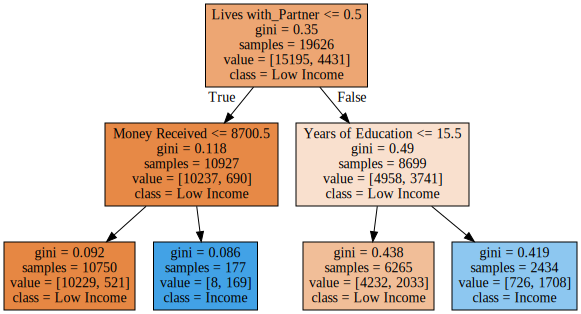

In [75]:
plot_tree(dt_depth2)

In [76]:
dt_min10 = DecisionTreeClassifier(min_samples_split = 10).fit(X_train, y_train)

In [77]:
dt_min500 = DecisionTreeClassifier(min_samples_split = 500).fit(X_train, y_train)

df = pd.DataFrame(columns = ['Time','Train','Test'], index = ['dt_min10','dt_min500'])
show_results(df, dt_min10, dt_min500)

,Time,Train,Test
dt_min10,0.157+/-0.03,0.921+/-0.0,0.832+/-0.01
dt_min500,0.106+/-0.02,0.863+/-0.0,0.857+/-0.01


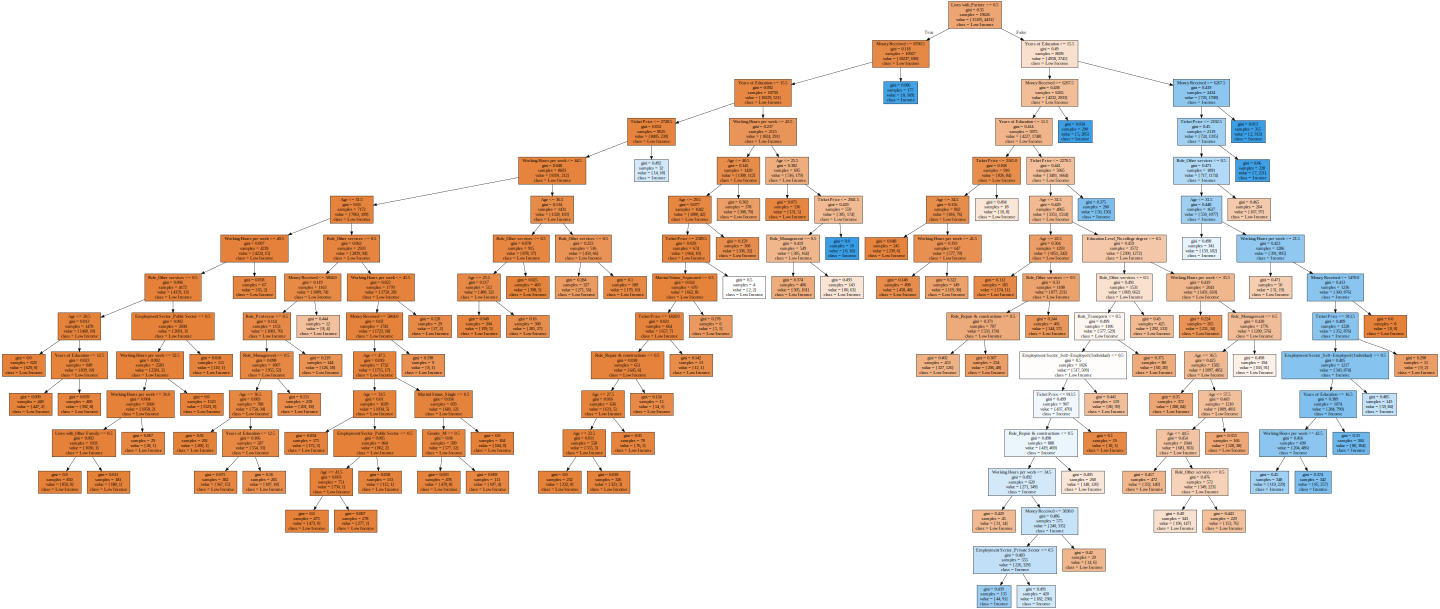

In [78]:
plot_tree(dt_min500)

In [79]:
dt_min_sam200 = DecisionTreeClassifier(min_samples_leaf = 200).fit(X_train, y_train)

In [80]:
dt_min_sam500 = DecisionTreeClassifier(min_samples_leaf = 500).fit(X_train, y_train)

In [81]:
df = pd.DataFrame(columns = ['Time','Train','Test'], index = ['dt_min_sam1','dt_min_sam200','dt_min_sam500'])
show_results(df,dt_gini, dt_min_sam200, dt_min_sam500)

,Time,Train,Test
dt_min_sam1,0.167+/-0.03,0.968+/-0.0,0.817+/-0.01
dt_min_sam200,0.098+/-0.01,0.855+/-0.0,0.852+/-0.01
dt_min_sam500,0.08+/-0.01,0.834+/-0.0,0.833+/-0.01


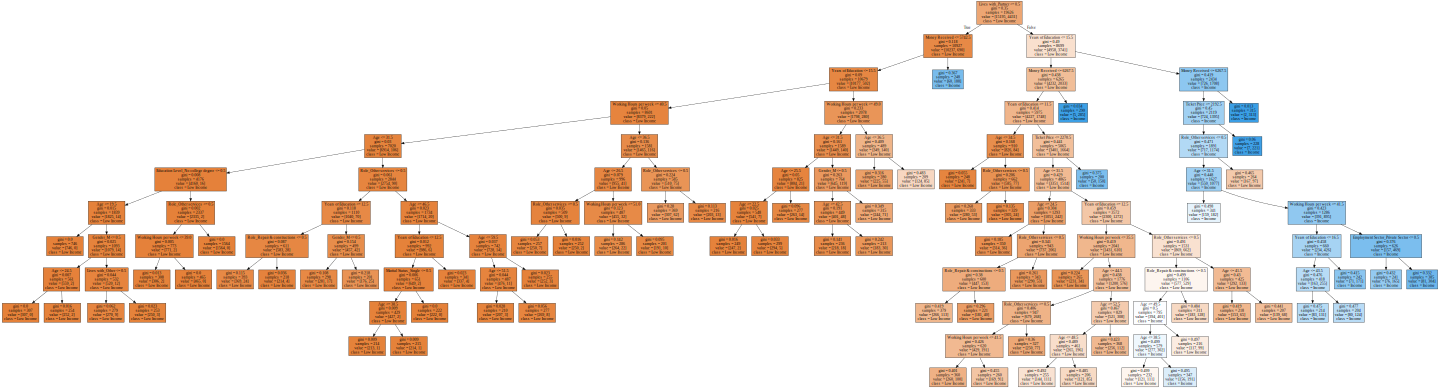

In [82]:
plot_tree(dt_min_sam200)

In [83]:
dt_min_weight = DecisionTreeClassifier(min_weight_fraction_leaf = 0.15).fit(X_train, y_train)

df = pd.DataFrame(columns = ['Time','Train','Test'], index = ['dt_gini','dt_min_weight'])
show_results(df,dt_gini, dt_min_weight)

,Time,Train,Test
dt_gini,0.185+/-0.03,0.968+/-0.0,0.817+/-0.01
dt_min_weight,0.038+/-0.01,0.807+/-0.0,0.807+/-0.01


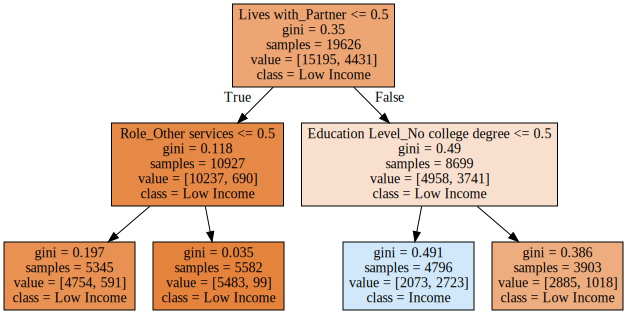

In [84]:
plot_tree(dt_min_weight)

In [85]:
dt_none = DecisionTreeClassifier(max_features = None).fit(X_train, y_train)
dt_int = DecisionTreeClassifier(max_features = 2).fit(X_train, y_train)
dt_float = DecisionTreeClassifier(max_features = 0.5).fit(X_train, y_train)
dt_auto = DecisionTreeClassifier(max_features = 'auto').fit(X_train, y_train)
dt_log2 = DecisionTreeClassifier(max_features = 'log2').fit(X_train, y_train)

In [86]:
df = pd.DataFrame(columns = ['Time','Train','Test'], index = ['None (Baseline)','Int','Float','Auto','Log2'])
show_results(df,dt_none, dt_int, dt_float, dt_auto, dt_log2)

,Time,Train,Test
None (Baseline),0.17+/-0.03,0.968+/-0.0,0.817+/-0.01
Int,0.048+/-0.01,0.968+/-0.0,0.815+/-0.01
Float,0.115+/-0.03,0.968+/-0.0,0.817+/-0.01
Auto,0.074+/-0.02,0.968+/-0.0,0.821+/-0.01
Log2,0.052+/-0.0,0.968+/-0.0,0.819+/-0.01


In [87]:
dt_int2 = DecisionTreeClassifier(max_features = 2, max_depth = 2).fit(X_train, y_train)
dt_int3 = DecisionTreeClassifier(max_features = 2, max_depth = 2).fit(X_train, y_train)

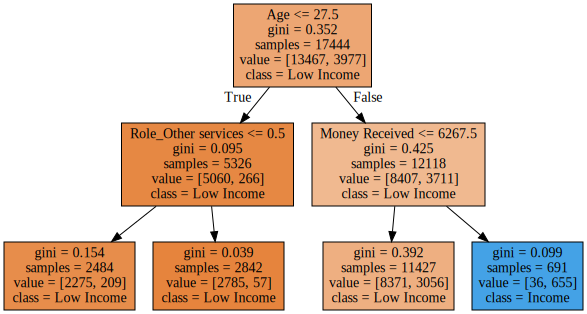

In [88]:
plot_tree(dt_int2)

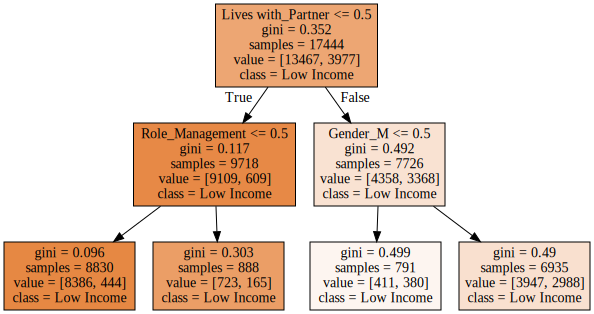

In [89]:
plot_tree(dt_int3)

In [90]:
dt_maxleaf5 = DecisionTreeClassifier(max_leaf_nodes = 5).fit(X_train, y_train)

df = pd.DataFrame(columns = ['Time','Train','Test'], index = ['Baseline','dt_maxleaf5'])
show_results(df,dt_gini, dt_maxleaf5)

,Time,Train,Test
Baseline,0.167+/-0.02,0.968+/-0.0,0.818+/-0.01
dt_maxleaf5,0.054+/-0.01,0.845+/-0.0,0.845+/-0.01


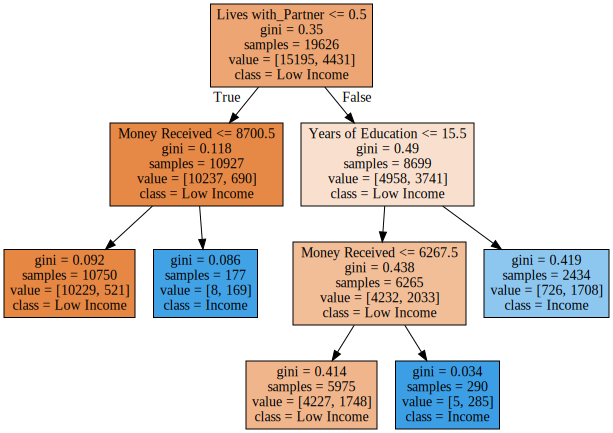

In [91]:
plot_tree(dt_maxleaf5)

In [93]:
dt_impurity02 = DecisionTreeClassifier(min_impurity_decrease=0.02).fit(X_train, y_train)

df = pd.DataFrame(columns = ['Time','Train','Test'], index = ['Baseline','dt_impurity04'])
show_results(df,dt_gini, dt_impurity02)

,Time,Train,Test
Baseline,0.172+/-0.02,0.968+/-0.0,0.817+/-0.01
dt_impurity04,0.044+/-0.01,0.823+/-0.0,0.823+/-0.01


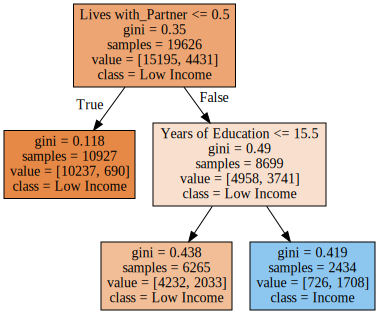

In [94]:
plot_tree(dt_impurity02)

In [95]:
gini_importance = DecisionTreeClassifier().fit(X_train, y_train).feature_importances_
entropy_importance = DecisionTreeClassifier(criterion='entropy').fit(X_train, y_train).feature_importances_

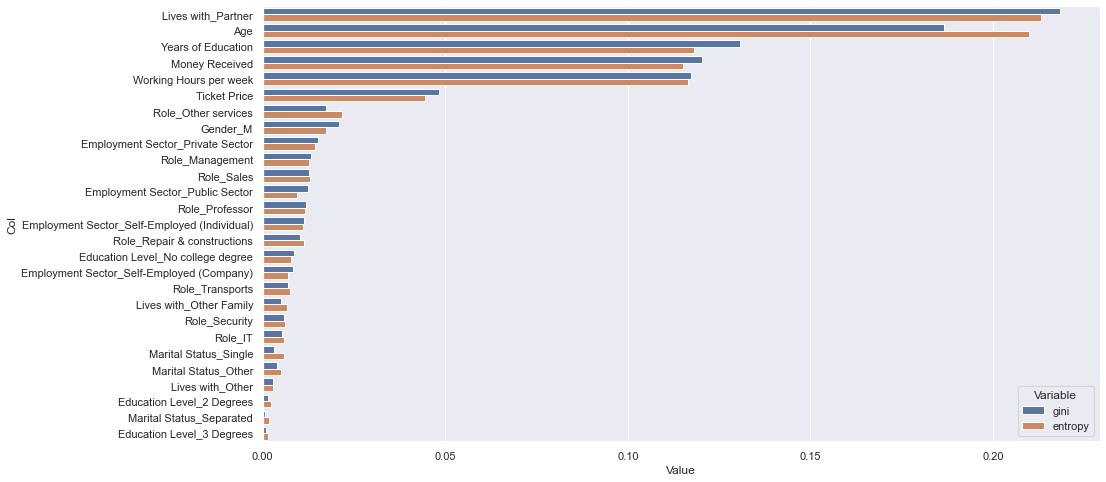

In [96]:
import seaborn as sns

zippy = pd.DataFrame(zip(gini_importance, entropy_importance), columns = ['gini','entropy'])
zippy['col'] = X_train.columns
tidy = zippy.melt(id_vars='col').rename(columns=str.title)
tidy.sort_values(['Value'], ascending = False, inplace = True)

plt.figure(figsize=(15,8))
sns.barplot(y='Col', x='Value', hue='Variable', data=tidy)